In [1]:
pip install -U sentence-transformers

In [2]:
!pip install pyspellchecker

In [3]:
#Connecting to the drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Importing the necessary libraries 

import numpy as np 
import pandas as pd 
import nltk
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from transformers import AutoTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('wordnet')
from nltk.corpus import brown
from gensim.models import Word2Vec
nltk.download('brown')
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [5]:
# importing training dataset
df = pd.read_csv('/content/drive/My Drive/data/train.csv')

In [6]:
# importing dataset for product catalogue
df_product = pd.read_csv('/content/drive/My Drive/data/product_catalogue.csv')

In [7]:
df_product = df_product[df_product["product_locale"]=='us']

In [8]:
df_product.head(5)

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
0,B0188A3QRM,"Amazon Basics Woodcased #2 Pencils, Unsharpene...",NaN,144 woodcase #2 HB pencils made from high-qual...,Amazon Basics,Yellow,us
1,B075VXJ9VG,"BAZIC Pencil #2 HB Pencils, Latex Free Eraser,...",<p><strong>BACK TO BAZIC</strong></p><p>Our go...,&#11088; UN-SHARPENED #2 PREMIUM PENCILS. Each...,BAZIC Products,12-count,us
2,B07G7F6JZ6,Emraw Pre Sharpened Round Primary Size No 2 Ju...,<p><b>Emraw Pre-Sharpened #2 HB Wood Pencils -...,✓ PACK OF 8 NUMBER 2 PRESHARPENED BEGINNERS PE...,Emraw,Yellow,us
3,B07JZJLHCF,Emraw Pre Sharpened Triangular Primary Size No...,<p><b>Emraw Pre-Sharpened #2 HB Wood Pencils -...,✓ PACK OF 6 NUMBER 2 PRESHARPENED BEGINNERS PE...,Emraw,Yellow,us
4,B07MGKC3DD,"BIC Evolution Cased Pencil, #2 Lead, Gray Barr...",NaN,Premium #2 HB lead pencils with break-resistan...,Design House,Gray,us


The code containes data collected from US and Japan. The data collected from Japan is in Japanese language while the one from the US is in English. We will be working with data from the US only

In [9]:
df = df[df["query_locale"]=='us']

In [10]:
df

,query_id,query,query_locale,product_id,esci_label
0,0,# 2 pencils not sharpened,us,B0000AQO0O,exact
1,0,# 2 pencils not sharpened,us,B0002LCZV4,exact
2,0,# 2 pencils not sharpened,us,B00125Q75Y,exact
3,0,# 2 pencils not sharpened,us,B001AZ1D3C,exact
4,0,# 2 pencils not sharpened,us,B001B097KC,exact
...,...,...,...,...,...
419725,18848,zephyr polishing kit,us,B081SYK6R2,irrelevant
419726,18848,zephyr polishing kit,us,B087HZQY4V,complement
419727,18848,zephyr polishing kit,us,B08H4ZJ6Q1,substitute
419728,18848,zephyr polishing kit,us,B08LSN8MT8,substitute


The train data only has product id but no further information on the product. So we map the  product description, product brands and product product_bullet_points (that describes the product attributes) from Product dataframe to training data with respect to its product id

In [11]:
# Merging data from train and product dataframe
df = (df.merge(df_product, left_on='product_id', right_on='product_id')
          .reindex(columns=['query_id', 'query', 'query_locale', 'product_id','product_title', 'product_brand', 'product_bullet_point', 'product_color_name', 'esci_label']))
df = df.drop('query_locale', 1)
df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,query_id,query,product_id,product_title,product_brand,product_bullet_point,product_color_name,esci_label
0,0,# 2 pencils not sharpened,B0000AQO0O,"Ticonderoga Beginner Pencils, Wood-Cased #2 HB...",Ticonderoga,Round wood pencil with latex-free eraser\nFini...,Yellow,exact
1,8799,pencils for kindergarteners,B0000AQO0O,"Ticonderoga Beginner Pencils, Wood-Cased #2 HB...",Ticonderoga,Round wood pencil with latex-free eraser\nFini...,Yellow,exact
2,14844,#2 dixon oriole pencils not sharpened,B0000AQO0O,"Ticonderoga Beginner Pencils, Wood-Cased #2 HB...",Ticonderoga,Round wood pencil with latex-free eraser\nFini...,Yellow,substitute
3,15768,#2 pencils with erasers sharpened not soft,B0000AQO0O,"Ticonderoga Beginner Pencils, Wood-Cased #2 HB...",Ticonderoga,Round wood pencil with latex-free eraser\nFini...,Yellow,substitute
4,16972,classroom friendly supplies pencil sharpener,B0000AQO0O,"Ticonderoga Beginner Pencils, Wood-Cased #2 HB...",Ticonderoga,Round wood pencil with latex-free eraser\nFini...,Yellow,irrelevant
5,0,# 2 pencils not sharpened,B0002LCZV4,"TICONDEROGA Tri-Write Triangular Pencils, Stan...",Ticonderoga,Triangular shape to promote proper grip\nExclu...,Yellow,exact
6,15768,#2 pencils with erasers sharpened not soft,B0002LCZV4,"TICONDEROGA Tri-Write Triangular Pencils, Stan...",Ticonderoga,Triangular shape to promote proper grip\nExclu...,Yellow,exact
7,0,# 2 pencils not sharpened,B00125Q75Y,"TICONDEROGA Pencils, Wood-Cased, Unsharpened, ...",Ticonderoga,Exclusive #2 graphite formula provides extra s...,Yellow,exact
8,8800,pencils that say collin,B00125Q75Y,"TICONDEROGA Pencils, Wood-Cased, Unsharpened, ...",Ticonderoga,Exclusive #2 graphite formula provides extra s...,Yellow,substitute
9,14844,#2 dixon oriole pencils not sharpened,B00125Q75Y,"TICONDEROGA Pencils, Wood-Cased, Unsharpened, ...",Ticonderoga,Exclusive #2 graphite formula provides extra s...,Yellow,substitute


In [12]:
print(df['esci_label'].value_counts());

exact         181856
substitute    147654
irrelevant     71125
complement     19095
Name: esci_label, dtype: int64


In [13]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 419730 entries, 0 to 419729
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   query_id              419730 non-null  int64 
 1   query                 419730 non-null  object
 2   product_id            419730 non-null  object
 3   product_title         419658 non-null  object
 4   product_brand         399197 non-null  object
 5   product_bullet_point  371076 non-null  object
 6   product_color_name    290488 non-null  object
 7   esci_label            419730 non-null  object
dtypes: int64(1), object(7)
memory usage: 28.8+ MB


In [14]:
df.describe(include='object')

,query,product_id,product_title,product_brand,product_bullet_point,product_color_name,esci_label
count,419730,419730,419658,399197,371076,290488,419730
unique,20888,352028,348284,95642,274088,61435,4
top,airpods,B01HFFXLNA,Episode 1,Nike,Used Book in Good Condition,Black,exact
freq,188,59,93,2251,671,48832,181856


In [15]:
len(df['product_id'].unique())

352028

In [16]:
# Checking for null values in training data
df.isnull().sum()

query_id                     0
query                        0
product_id                   0
product_title               72
product_brand            20533
product_bullet_point     48654
product_color_name      129242
esci_label                   0
dtype: int64

As observed from the dataframe `product_df`, the product bullet points have elements of product title and product titles can come close to what has been used as queries. So, we will be filling the null values in `product_title` with corresponding queries and `product_bullet_point` with corresponding product titles

In [17]:
df.product_title.fillna(df.query, inplace=True)

In [18]:
df.product_bullet_point.fillna(df.product_title, inplace=True)

Also, for brand name, according to the data trend the first work in the product generally is the band's name that manufactutred the product. So we will be filling the null spaces for brand name with the first word of the product title

In [19]:
df.product_brand.fillna(str(df.product_title.str.split()[0]), inplace=True)

In [20]:
df.isnull().sum()

query_id                     0
query                        0
product_id                   0
product_title                0
product_brand                0
product_bullet_point         0
product_color_name      129242
esci_label                   0
dtype: int64

In [21]:
sample_data=df.iloc[101]
sample_data
print('query \n',sample_data.query)
print('\nProduct Title \n',sample_data.product_title)
print('\nProduct Brand \n',sample_data.product_brand)
print('\nProduct Colour \n',sample_data.product_color_name)
print('\nProduct Description \n',sample_data.product_bullet_point)

query 
 # mom life

Product Title 
 MACCHIASHINE Unique Sleeveless MOM Life Printed Shirt Womens Cotton Tank Tops(GR-XL) Green

Product Brand 
 MACCHIASHINE

Product Colour 
 Green

Product Description 
 Material: Soft Cotton,comfortable touching
Lightweight 0.12kg;（Necklace NOT included)
Features: MOM LIFE printed fashion sleeveless ovesized tank tops,poll-on Casual tyle,Solid color womens girls basic vests
Size Details: S.M.L.XL. Pls Carefully Refer to the Size Details below before placing order.(Pls choose 1-2 SIZE UP than usual)
Suitable Occasion: Casual/Date/Home/Party/Work/Shopping/Exercise


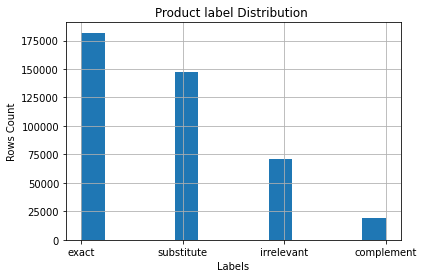

In [22]:
df['esci_label'].hist(bins=13);
plt.xlabel("Labels");
plt.ylabel("Rows Count");
plt.title('Product label Distribution ');

Finding top 10 frequently searched products

In [23]:
frequently_used_query = pd.DataFrame(df.groupby('query')['esci_label'].count())
most_common_query = frequently_used_query.sort_values('esci_label', ascending=False)
most_common_query.head(10)

,esci_label
query,
airpods,188
printer,136
face mask,109
apple watch series 3,98
apple headphones,94
barbie dolls,87
echo dot,84
prime movies,84
iphone xr,83


BASIC PREPROCESSING

Our goal here is to find the similarity between the query used to search the product and the actual text used for product. In order to do this it is necessary for us to clean text so that a rubust relationship chan be established between query and product title.

The measuring units in the products are not uniform. for example for unit pounds some title uses `lb` while the others use `lbs` or `pounds`. This non uniformity makes it hard to establish relationship between sentences to compare similarities. 

Similarly spacing is added between numeric values and alphabets. In instances like `5vitamins` and `5 vitamins` refer to same product but no similarity can be found in them. so the numbers and alphabets are spaced in such case. 
Another case we need to take care of are spaces befor and after `-`s and `\`s to resolve similar case.

Beside these case specific cleaning, we are also changing all text to lowercase and removing extra white spaces to get clean data before we can perform further operations



In [24]:
import re 

def pre_process_text(product_title):
  if type(product_title) is str:
    keywords = product_title.replace('-', ' - ')
    keywords = product_title.replace('/', ' / ')
    keywords = re.split(r'\W+', product_title) 
    keywords = [keyword.lower() for keyword in keywords] #converting all text to lowercase
    clean_words = re.sub("[A-Za-z]+", lambda w: " " + w[0] + " ", ' '.join(keywords)) #add space between number and alphabets in a string
    processed_text = " " + clean_words + " "
    # bringing varied way of showing mesurement units to same standard
    processed_text = re.sub('( pcs | pc )',' piece ',processed_text)
    processed_text = re.sub('( foot | ft | feets )',' feet ',processed_text)
    processed_text = re.sub('( in | inches )',' inch ',processed_text)
    processed_text = re.sub('( qt | quart )',' quarter ',processed_text)
    #replace '' or " with inch and ' with feet for measurement
    processed_text = re.sub("^[0-9]+\"|[0-9]+''",' inch ',processed_text)
    rocessed_text = re.sub("^[0-9]+'",' feet ',processed_text)
    # strip whitespaces
    processed_text = ' '.join(processed_text.split()) 
    return processed_text

df['product_title'] = df['product_title'].apply(lambda text : pre_process_text(text))
df['product_brand'] = df['product_brand'].apply(lambda text : pre_process_text(text))
df['product_bullet_point'] = df['product_bullet_point'].apply(lambda text : pre_process_text(text))
df['query'] = df['query'].apply(lambda text : pre_process_text(text))


In [25]:
df.head(6)

,query_id,query,product_id,product_title,product_brand,product_bullet_point,product_color_name,esci_label
0,0,2 pencils not sharpened,B0000AQO0O,ticonderoga beginner pencils wood cased 2 hb s...,ticonderoga,round wood pencil with latex free eraser finis...,Yellow,exact
1,8799,pencils for kindergarteners,B0000AQO0O,ticonderoga beginner pencils wood cased 2 hb s...,ticonderoga,round wood pencil with latex free eraser finis...,Yellow,exact
2,14844,2 dixon oriole pencils not sharpened,B0000AQO0O,ticonderoga beginner pencils wood cased 2 hb s...,ticonderoga,round wood pencil with latex free eraser finis...,Yellow,substitute
3,15768,2 pencils with erasers sharpened not soft,B0000AQO0O,ticonderoga beginner pencils wood cased 2 hb s...,ticonderoga,round wood pencil with latex free eraser finis...,Yellow,substitute
4,16972,classroom friendly supplies pencil sharpener,B0000AQO0O,ticonderoga beginner pencils wood cased 2 hb s...,ticonderoga,round wood pencil with latex free eraser finis...,Yellow,irrelevant
5,0,2 pencils not sharpened,B0002LCZV4,ticonderoga tri write triangular pencils stand...,ticonderoga,triangular shape to promote proper grip exclus...,Yellow,exact


**Lemmatization and removal of stop words**

In [26]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
 
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def stem_text(text): 
  if type(text) is str:
    data_texts = text.split()
    data_texts = [txt for txt in data_texts if not txt in stop_words]
    data_texts = [lemmatizer.lemmatize(word) for word in data_texts]
    return ' '.join(data_texts)

df['product_title'] = df['product_title'].apply(lambda txt : stem_text(txt)) 
df['product_brand'] = df['product_brand'].apply(lambda txt : stem_text(txt)) 
df['product_bullet_point'] = df['product_bullet_point'].apply(lambda txt : stem_text(txt)) 
df['query'] = df['query'].apply(lambda txt : stem_text(txt)) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
df.sample(6)

,query_id,query,product_id,product_title,product_brand,product_bullet_point,product_color_name,esci_label
221604,8163,neon pink food coloring,B07BMC6RV6,spice select neon food color blue green pink p...,spice supreme,includes 1 blue green pink purple made inch us...,NaN,substitute
10232,155,1 quarter wide mouth mason jar without lid,B07VQQY7NR,glass jar lid glass canister 48 oz 2 piece can...,klikel,quality clear glass set premium quality kitche...,Transparent,exact
159072,5298,hair scissors,B00KV5E6AY,se 2 piece barber thinning scissors set scb 201 p,se,barber scissors length 5 75 thinning scissors ...,Stainless Steel,exact
200999,7223,macbook pro 13 case touch bar,B01NCOLR2V,mosiso compatible macbook pro 13 inch case 201...,mosiso,compatible macbook pro 13 inch 2020 2019 2018 ...,Black,exact
364025,15513,house without window,0241986079,house without window,ticonderoga beginner pencil wood cased 2 hb so...,house without window,White,exact
89816,2475,carol daughter mimosa hair honey shine pomade,B00LI1SSFO,curly hair product carol daughter hair milk st...,carol daughter,curl defining cream creamy pudding defines sha...,NaN,substitute


In [28]:
#fill null values
df.product_title.fillna(df.query, inplace=True)
df.product_bullet_point.fillna(df.product_title, inplace=True)

Correct Typos

While the information have been obtained from the products in amazon, the `query` is user input. The user input may likely have typos which when corrected give better search results

In [29]:
from spellchecker import SpellChecker
check_spelling = SpellChecker()

In [30]:
# def correct_spelling(text, correction = 0):
#     words = []
#     for word in text.split(' '):
#         if word not in stop_words:
#             if correction == 1:
#                 if len(check_spelling.unknown([word])):
#                     word = check_spelling.correction(word)
#             words.append(word)
#     return ' '.join(words)

# df['query'] = df['query'].apply(lambda txt : correct_spelling(txt, correction = 1)) 

In [31]:
# this splits the text by uppercase alphabets but only if the uppercase letter is not followed by other alphabets of upper or lower case. 
# eg : Harry Potter VolI becomes Harry Potter Vol I 
df['query'] = df['query'].apply(lambda x: ' '.join(re.findall(r'[A-Z]?[^A-Z\s]+|[A-Z]+', x)))

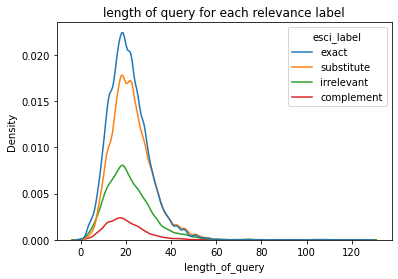

In [32]:
df['length_of_query'] = df['query'].str.len()
sns.kdeplot(data=df, x="length_of_query", hue="esci_label")
plt.title('length of query for each relevance label')
plt.show()

Here we check if query length has influence on finding relevant product.Most queries have length between 10-30. The distribution is almost similar for all 4 relevance label. The query length doesnt seem to have much meaningful impact

In [33]:
#using count vectorizer to find unigrams and bigrams from bag of words
def N_gram(data_texts, N_gram=None):
    count_vectors = CountVectorizer(ngram_range=(N_gram, N_gram)).fit(data_texts) 
    wordsum = count_vectors.transform(data_texts).sum(axis=0) 
    frequency_of_words = [(txt, wordsum[0, index]) 
                  for txt, index in count_vectors.vocabulary_.items()]
    frequency_of_words =sorted(frequency_of_words, key = lambda word: word[1], reverse=True)
    return frequency_of_words

In [34]:
df_exact = df[df['esci_label']=='exact']
df_substitute = df[df['esci_label']=='substitute']
df_irrelevant = df[df['esci_label']=='irrelevant']
df_complement = df[df['esci_label']=='complement']

**Trigram in descending order of frequency in search query for each class**

In [35]:
bigrams_exact=N_gram(df_exact['query'],2) 
print(bigrams_exact)

[('plus size', 824), ('shirt men', 591), ('high waisted', 572), ('without overflow', 519), ('year old', 500), ('drain without', 450), ('dress woman', 449), ('shirt woman', 439), ('shoe woman', 411), ('long sleeve', 405), ('big tall', 404), ('without light', 393), ('water bottle', 393), ('without lid', 374), ('iphone 11', 373), ('face mask', 369), ('shoe men', 363), ('ceiling fan', 340), ('apple watch', 337), ('chair without', 336), ('fan without', 328), ('watch men', 320), ('top woman', 319), ('phone case', 317), ('without needle', 303), ('without buckle', 298), ('iphone case', 298), ('without nail', 293), ('costume woman', 288), ('bed frame', 279), ('without sugar', 270), ('samsung galaxy', 268), ('throw pillow', 264), ('screen protector', 262), ('led light', 244), ('nail polish', 238), ('sink drain', 233), ('christmas tree', 233), ('gift card', 231), ('baby girl', 231), ('boot woman', 231), ('swimsuit woman', 229), ('curtain rod', 227), ('halloween costume', 224), ('car seat', 216), 

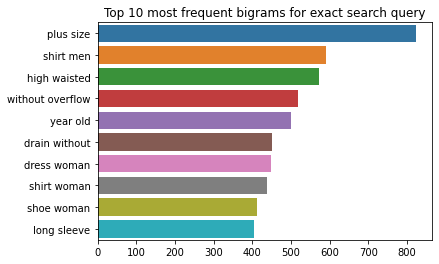

In [36]:
count, bigram =map(list,zip(*bigrams_exact[:10])) 
plt.title('Top 10 most frequent bigrams for exact search query')
sns.barplot(x=bigram,y=count)
plt.show()

In [37]:
bigrams_substitute=N_gram(df_substitute['query'],2) 
print(bigrams_substitute)

[('without lid', 620), ('water bottle', 459), ('plus size', 443), ('watch men', 366), ('without needle', 352), ('high waisted', 330), ('chair without', 329), ('shoe woman', 319), ('shirt woman', 307), ('without light', 305), ('shirt men', 299), ('without overflow', 291), ('shoe men', 290), ('without wheel', 287), ('dress woman', 281), ('without buckle', 280), ('nail polish', 277), ('long sleeve', 276), ('syringe without', 271), ('without handle', 268), ('throw pillow', 258), ('black white', 250), ('ceiling fan', 250), ('gift card', 244), ('drain without', 244), ('face mask', 244), ('phone case', 240), ('led light', 232), ('iphone 11', 231), ('stainless steel', 229), ('belt without', 218), ('christmas tree', 216), ('fan without', 215), ('bed frame', 212), ('top woman', 203), ('year old', 201), ('apple watch', 197), ('samsung galaxy', 194), ('iphone plus', 194), ('office chair', 192), ('picture frame', 185), ('10 inch', 185), ('without freezer', 182), ('without iron', 181), ('heavy duty'

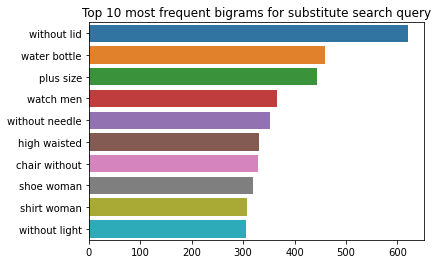

In [38]:
count, bigram =map(list,zip(*bigrams_substitute[:10])) 
plt.title('Top 10 most frequent bigrams for substitute search query')
sns.barplot(x=bigram,y=count)
plt.show()

In [39]:
bigrams_irrelevant=N_gram(df_irrelevant['query'],2) 
print(bigrams_irrelevant)

[('without lid', 338), ('plus size', 273), ('chair without', 256), ('without hole', 213), ('without wheel', 191), ('iphone 11', 187), ('gift card', 175), ('shirt woman', 174), ('year old', 162), ('would buy', 158), ('without light', 157), ('long sleeve', 151), ('without tear', 148), ('without arm', 136), ('without overflow', 133), ('without needle', 133), ('ceiling fan', 132), ('dress woman', 130), ('without handle', 130), ('shoe woman', 130), ('iphone case', 128), ('without vitamin', 127), ('phone case', 127), ('blu ray', 119), ('kit without', 117), ('shirt men', 115), ('fan without', 114), ('box without', 108), ('without iron', 107), ('11 pro', 106), ('toy woman', 105), ('without foot', 105), ('would choose', 101), ('without adhesive', 100), ('stainless steel', 97), ('drain without', 96), ('screen protector', 96), ('syringe without', 94), ('without end', 92), ('apple watch', 92), ('navy blue', 91), ('without buckle', 91), ('without hood', 89), ('office chair', 89), ('teen girl', 89),

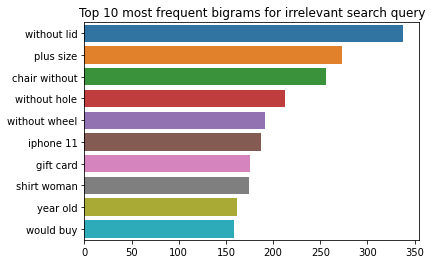

In [40]:
count, bigram =map(list,zip(*bigrams_irrelevant[:10])) 
plt.title('Top 10 most frequent bigrams for irrelevant search query')
sns.barplot(x=bigram,y=count)
plt.show()

In [41]:
bigrams_complement=N_gram(df_complement['query'],2) 
print(bigrams_complement)

[('throw pillow', 112), ('apple watch', 93), ('iphone 11', 86), ('11 pro', 82), ('iphone xr', 69), ('pro max', 66), ('samsung galaxy', 65), ('shampoo conditioner', 59), ('golf cart', 54), ('watch series', 50), ('table saw', 50), ('echo dot', 48), ('water bottle', 46), ('ipod touch', 46), ('wine without', 42), ('th generation', 41), ('xbox one', 41), ('contact lens', 41), ('outdoor pillow', 40), ('without handle', 39), ('without sulfites', 39), ('polaris ranger', 37), ('hydro flask', 36), ('costume woman', 36), ('pillow cover', 35), ('fish tank', 35), ('straw lid', 33), ('dw drum', 33), ('10 foot', 32), ('apple airpods', 31), ('table chair', 30), ('costume adult', 30), ('wyze cam', 30), ('10 plus', 29), ('iphone max', 29), ('mask without', 29), ('without tear', 29), ('galaxy note', 28), ('zxi 900', 28), ('without lid', 27), ('fire stick', 27), ('blue throw', 27), ('charging case', 26), ('curtain rod', 26), ('cold brew', 26), ('instant pot', 26), ('propane tank', 26), ('shower curtain', 

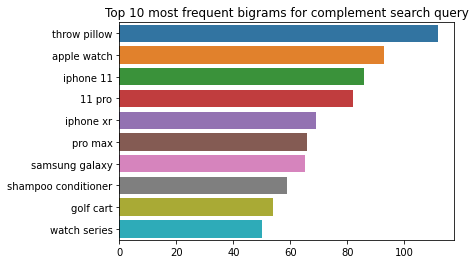

In [42]:
count, bigram =map(list,zip(*bigrams_complement[:10])) 
plt.title('Top 10 most frequent bigrams for complement search query')
sns.barplot(x=bigram,y=count)
plt.show()

LABEL ENCODING

In [43]:
# Encoding categorical label into numerical 
relevance_label = ('exact','substitute','irrelevant','complement')
label_df = pd.DataFrame(relevance_label, columns=['relevance_label'])
labelencoder = LabelEncoder()
label_df

,relevance_label
0,exact
1,substitute
2,irrelevant
3,complement


In [44]:
search_relevance = ('exact','substitute','irrelevant','complement')
labelencoder = LabelEncoder()
df['esci_label'] = labelencoder.fit_transform(df['esci_label'])
df.sample(6)

,query_id,query,product_id,product_title,product_brand,product_bullet_point,product_color_name,esci_label,length_of_query
201310,7236,madden 20 xbox one,B07W2ZWDPH,madden nfl 20 mut 5850 madden point pack piece...,electronic art,madden ultimate team mut complete nfl team bui...,NaN,3,18
324332,13344,cosas de escritorio,B0823RL8BD,sumikko gurashi round design pencil bag pencil...,magic channel,pencil pouch made soft waterproof pu leather d...,Pink,2,19
242827,9151,plus size straight leg slack woman,B07B9Q6FRK,lee woman plus size relaxed fit day pant deep ...,lee,mid rise relaxed fit featuring flexible waistb...,Deep Breen,1,34
12896,217,1 4 inch galvanized anchor chain,B084T6V6ZW,five ocean windlass anchor rode nylon three st...,five ocean,ideal use windlass professional anchor rode ma...,1/2in by 100ft Rope with 1/4in by 15ft Chain,1,32
403173,17854,opal ice maker filter,B0751KDVTP,firstbuild opal countertop nugget ice maker,firstbuild,countertop size elegant design opal wow guest ...,Stainless Steel Wrap with Black Accents,2,21
258744,9892,roof tile,B00GZLHM4K,osi rt 600 terracotta roof tile adhesive 10 ou...,osi,package dimension 5 08 cm l x 5 08 cm w x 29 2...,"Terracotta, Grey",0,9


In [45]:
df.drop(['length_of_query'], axis = 1, inplace = True) 

In [46]:
df.product_title.fillna(df.query, inplace=True)
df.product_bullet_point.fillna(df.product_title, inplace=True)
df.product_color_name.fillna('', inplace=True) # product color is secondary, hence for null value we will be passing empty string for colors

The query text need to match with the  product text to return a match. the product has its title name, description and brand that can be associated with the query text. So we combine the text related to product information to make the comparison easier.

In [47]:
columns = ['product_title', 'product_bullet_point', 'product_brand', 'product_color_name']
df['product_text'] = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [48]:
df.drop(['product_title', 'product_bullet_point', 'product_brand', 'product_color_name'], axis=1, inplace=True)
df.sample(5)

,query_id,query,product_id,esci_label,product_text
202967,7307,mandolorian,B08HYDY3SV,1,rusiaju dust mask mandolorian reusable cycling...
282984,11126,study bible kjv teen boy,1462762298,1,kjv kid bible royal blue leathertouch kjv kid ...
3908,48,22 pellet lead,B00CI1WE7Q,1,gamo whisper pellet qty 100 blister 632272354 ...
304021,12242,vintage dress woman,B07PSHS75Q,3,homeyee woman vintage bow casual polka dot ali...
105359,3094,cooler master אם קר,B07DF2SP3X,1,cooler master mastercase h 500 argb airflow at...


CREATING VECTORS USING Word2vec FOR INFORMATION RETRIEVAL USING VECTOR SPACE MODEL

Since we have text data, it needs to be represented a numbers  i.e inI mean vector form. `Word2vec` is being used here to achieve that as it converts words into vectors while keeping the semantical and syntactical relationship of words intact.

In [49]:
# Creating data for the model training
corpus= []

query = df['query'].values
product_text = df['product_text'].values

def create_corpus(text):
  for i in range(len(query)):
    corpus.append(query[i].split())

create_corpus(query)
create_corpus(product_text)

In [50]:
# Training model from the  corpus we created from our dataset
search_model = Word2Vec(corpus, size=250, min_count=2,window=5, sg=1,workers=4)

In [51]:
print('Size of the vocab:', len(search_model.wv.vocab))

Size of the vocab: 13431


In [52]:
# reperesentating texts as vectors 
def get_word_vectors(search_tokens):
    wrd_embed = []
    if len(search_tokens)<1:
        return np.zeros(250)
    else:
        for token in search_tokens:
            if token in search_model.wv.vocab:
                wrd_embed.append(search_model.wv.word_vec(token))
            else:
                wrd_embed.append(np.random.rand(250))
        return np.mean(wrd_embed, axis=0)    # calculate the mean of vectos of each words for overall vector

df['query'] = df['query'].apply(lambda w :get_word_vectors(w.split()) if type(w) is str else '')
df['product_text'] = df['product_text'].apply(lambda w :get_word_vectors(w.split()) if type(w) is str else '')

In [53]:
df.sample(5) 

,query_id,query,product_id,esci_label,product_text
185117,6494,"[0.039231583, 0.26117036, -0.016728356, -0.103...",B088ZM2Q7R,1,"[0.09688124125701864, 0.3123606441983559, -0.0..."
163675,5501,"[-0.20677765, 0.08667812, 0.10797226, 0.504041...",B07TMYB3NS,3,"[0.10951979354619255, 0.27630760088631695, -0...."
118601,3595,"[0.05040385, -0.34631038, 0.18873498, -0.18185...",B07FNBTY2F,1,"[0.07894737112212893, 0.18426604594203083, 0.0..."
77672,2014,"[-0.009006705, 0.2744421, -0.115363225, -0.069...",B0159WGSFY,3,"[0.11411193015457877, 0.29890528304334, -0.003..."
141354,4533,"[-0.021395108, 0.048451602, 0.0031472347, 0.51...",B071LTYH9Z,3,"[0.1607857062526687, 0.1562746796672779, 0.030..."


In [54]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity in quesy and product and calculate
def average_precision(query_id,query, product):
  
  # Get ground truth and product vectors
  ground_truth =df.loc[df['query_id']==query_id,['query','product_text']]
  
  # Ranking documents for the query
  df['similarity']=ground_truth['query'].apply(lambda x: cosine_similarity(np.array(product).reshape(1, -1),np.array(x).reshape(1, -1)).item())
  df.sort_values(by='similarity',ascending=False,inplace=True)

  # Ranking Top 10 products by similarity score
  rank=df.head(10)['similarity'].values
  
  # presicion calculation
  mean_avg_precision=[]
  for i in range(1,8):
    if rank[i-1]:
      mean_avg_precision.append(np.sum(rank[:i])/i)
  
  if mean_avg_precision==[]:
    return 0

  return np.mean(mean_avg_precision)

# Calculating average precision for all queries in the test set
df['AP']=df.apply(lambda x: average_precision(x['query_id'],x['query'], x['product_text']),axis=1)

# Finding Mean Average Precision
print('Mean Average Precision=>',df['AP'].mean())

Mean Average Precision=> 0.6119489025339347


In [63]:
df = df.drop('AP', 1)
df.head(5)

,query_id,query,product_id,esci_label,product_text,similarity
5022,63,"[-0.050902568, -0.18287396, 0.11213769, 0.1374...",B00AZWYUA4,1,"[0.2025589897528482, 0.23592547450674656, 0.10...",0.632379
5020,63,"[-0.050902568, -0.18287396, 0.11213769, 0.1374...",B004AMEOZG,2,"[0.08380478378161116, 0.07156367621437207, -0....",0.632379
5017,63,"[-0.050902568, -0.18287396, 0.11213769, 0.1374...",B0031450XY,3,"[0.1407073632172678, 0.18506185337966363, 0.10...",0.632379
5007,63,"[-0.050902568, -0.18287396, 0.11213769, 0.1374...",B0006HXQXA,1,"[0.0776666815731914, 0.22133194655614388, 0.15...",0.632379
5013,63,"[-0.050902568, -0.18287396, 0.11213769, 0.1374...",B001T6QCJC,3,"[0.1758094176033482, 0.22056496028155886, 0.09...",0.632379


In [70]:
def ranking_ir(query):
  
  # pre-process Query
  query=query.lower()
  query=pre_process_text(query)
  query=stem_text(query)
  query=re.sub(' +',' ',query)

  # generating vector
  vector=get_word_vectors(query.split())

  # ranking documents
  documents=df[['query_id','query','product_text']].copy()
  documents['similarity']=df['product_text'].apply(lambda x: cosine_similarity(np.array(vector).reshape(1, -1),np.array(x).reshape(1, -1)).item())
  documents.sort_values(by='similarity',ascending=False,inplace=True)
  
  return documents.head(10).reset_index(drop=True)

In [ ]:
# X = df.drop('similarity', 1)
# Y = df['similarity']
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=243)